<h1 style="font-size: 40px; margin-bottom: 0px;">12.1 Principal Component Analysis</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 700px;"></hr>

<p>Last week, we played around with our raw counts data in Python, and today, we'll switch over to R to start diving deeper into our counts. If you take a look at the kernel at the top right, you'll see that it's running using R rather than Python. We'll import our matrices that we created using our Python script, perform some normalization and filtering with DESeq2, and then use those values to perform a principal component analysis to get an idea of whether a notable difference exists between our control and TAZ KO replicates. By performing a principal component analysis on our replicates, we'll also be able to see whether there may have been batch effects that we may need to keep in mind in our analyses.</p>

<p><strong>Learning objectives:</strong></p>

<ul>
    <li>Working with data in R</li>
    <ul>
        <li>Normalization using DESeq2</li>
        <li>Basic filtering</li>
    </ul>
    <li>Review concept of principal component analysis</li>
    <li>Perform a principal component analysis</li>
</ul>

<h1>Loading in packages</h1>

Like with Python, R has a bunch of different packages to help with data analysis and visualization. The first thing we'll do is load in some packages and install additional ones that we'll need to normalize and filter our data, as well as perform a principal component analysis and generate plots.

<h2>Differential expression</h2>

The main package that we'll be using is called <a href="https://bioconductor.org/packages/release/bioc/html/DESeq2.html" rel="noopener noreferrer" target="_blank"><u>DESeq2</u></a>, which is one of the major packages commonly used to perform differential expression analysis. The other package that is also commonly used for differential expression analysis is called <a href="https://bioconductor.org/packages/release/bioc/html/edgeR.html" rel="noopener noreferrer" target="_blank"><u>edgeR</u></a>.

<a href="https://bioconductor.org/packages/release/bioc/html/DESeq2.html" rel="noopener noreferrer" target="_blank"><u>Documentation for DESeq2 can be found here.</u></a> DESeq2 was developed by Michael Love, Wolfgang Huber, and Simon Anders and published in <a href="https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8" rel="noopener noreferrer" target="_blank"><u>Love et al 2014 Genome Biology</u></a>. This package allows us to identify differentially expressed genes from a raw counts matrix. This  <a href="https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html" rel="noopener noreferrer" target="_blank"><u>A guided walkthrough example (vignette) can be found here</u></a>, and it contains helpful explanations of the different steps of DESeq2. We'll be performing a similar analysis here with some slight modifications.

<h2>Data visualization</h2>

One of the major packages for data visualization in R is <a href="https://ggplot2.tidyverse.org/" rel="noopener noreferrer" target="_blank"><u>ggplot2</u></a>, which was developed by <a href="https://ggplot2.tidyverse.org/authors.html" rel="noopener noreferrer" target="_blank"><u>Hadley Wickham, Winston Chang, Lionel Henry, Thomas Lin Pedersen, Kohske Takahashi, Claus Wilke, Kara Woo, Hiroaki Yutani, Dewey Dunnington, and Teun van den Brand</u></a>.

ggplot2 follows a specific framework to visualize data in a large variety of ways. A very basic way of viewing it is as layers of components that are added on top of each other in order to produce a final visualization. So each layer can be separately modified to produce more complex visualization. <a href="https://ggplot2.tidyverse.org/articles/ggplot2.html" rel="noopener noreferrer" target="_blank"><u>A more detailed explanation can be found here.</u></a>

Other packages for data visualization that we'll use are:
<ul>
    <li><a href="https://www.bioconductor.org/packages/2.8/bioc/html/hexbin.html" rel="noopener noreferrer" target="_blank"><u>hexbin</u></a> - to bin and plot data into hexagonal bins</li>
    <li><a href="https://www.bioconductor.org/packages/release/bioc/html/vsn.html" rel="noopener noreferrer" target="_blank"><u>vsn</u></a> - to visualize normalized transcriptomics data</li>
</ul>

<h2>'Omics data exploration</h2>

mixOmics is an R package containing a number of methods that facilitate both single 'omics and multivariate 'omics analyses. We'll be making use of mixOmics to perform a principal component analysis of our class transcriptome dataset to determine how our replicates compare to one another. Instead of clustering our datasets by each gene, we'll be clustering our dataset by samples.

miXomics was developed by a core team including: Kim-Anh Le Cao, Florian Rohart, and Sebastien Dejean and published in <a href="https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005752" rel="noopener noreferrer" target="_blank"><u>PLoS Comp Biol 2017.</u></a>
<a href="https://www.bioconductor.org/packages/release/bioc/html/mixOmics.html" rel="noopener noreferrer" target="_blank"><u>Documentation for mixOmics can be found here</u></a>, and <a href="http://mixomics.org/" rel="noopener noreferrer" target="_blank"><u>additional information here.</u></a> 

In [1]:
library(DESeq2)
library(ggplot2)
BiocManager::install("mixOmics")
BiocManager::install("hexbin")
BiocManager::install("vsn")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



<h1>Import class counts dataset and metadata file</h1>

Like with Python, we'll have to import our dataset into a dataframe matrix, which we can normalize, filter, and perform differential expression analysis.

The syntax is different than Python, but the concept is fundamentally the same.


```
counts <- read.csv('~/MCB201B_F2024/Week_11/1M-class-counts.csv',
                   stringsAsFactors=FALSE, 
                   row.names=1
                  )
```

Let's break down this line of code:

<code>counts</code>

This is our variable to which we will assign our dataframe matrix.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&lt;-</code>

This is the R assignment operator that assigns a variable on the left the object on the right.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>read.csv()</code>

This is the function to read in our .csv file into a dataframe.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>'~/MCB201B_F2024/Week_11/1M-class-counts.csv'</code>

This specifies the file path and file name of the .csv file that we want to load into our notebook.

<code>stringsAsFactors=FALSE</code>

This argument is refers to a data type particular to R, called a <code>factor</code>. This data type represents categorical data, allowing it to be ordered if needed by assigning them pre-defined values called levels. This comes in handy when plotting, where you can specify the ordering of your categrorical data by pre-defining their levels.

By setting this argument to <code>FALSE</code>, we stop R from converting our strings to factors.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>row.names=1</code>

This argument sets the index of our dataframe as the first column in our .csv file. Another way of reading this is that the names of each row is the values of the first column. 

In [2]:
counts <- read.csv('~/MCB201B_F2024/Week_12/1M_counts_matrix.csv',
                   stringsAsFactors=FALSE,
                   row.names=1
                   )

Now let's take a look at the first 6 rows of our imported dataframe to make sure it imported correctly.

```
head(counts)
```

Like with Python and Terminal, <code>head</code> refers to the first set of rows in your data. In Python, the default head is 5 rows. For Terminal, it's 10 rows. And for R, it's 6 rows.

If we want to specify 5 rows, we would just provide an extra argument indicating the number of rows we want to display.

```
head(counts, 5)
```

This will output 5 rows rather than 6.

In [52]:
head(counts, 5)

,ctrl_g1,tazko_g1,ctrl_g2,tazko_g2,ctrl_g3,tazko_g3,ctrl_g4,tazko_g4,ctrl_g5,tazko_g5,ctrl_g6,tazko_g6,ctrl_g7,tazko_g7,ctrl_g8,tazko_g8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A1BG,0,2,1,6,0,1,1,2,1,1,0,0,1,1,0,1
A1BG-AS1,3,2,2,2,4,3,2,1,1,1,2,2,1,0,3,0
A1CF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
A2M-AS1,0,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0


<h2>Exercise #1: Import metadata file</h2>

Now see if you can import your metadata file using the same setup that we used above. Name your variable <code>conditions</code>.

In [3]:
conditions <- read.csv('~/MCB201B_F2024/Week_10/quant/1M_conditions_matrix.csv',
                   stringsAsFactors=FALSE,
                   row.names=1
                   )

Then, check the first five rows to make sure the file imported correctly.

In [54]:
head(conditions, 5)

,condition
,<chr>
1M_g1_control,control
1M_g1_tazko,taz_ko
1M_g2_control,control
1M_g2_tazko,taz_ko
1M_g3_control,control


In [55]:
rownames(conditions)

[1] "1M_g1_control" "1M_g1_tazko"   "1M_g2_control" "1M_g2_tazko"  
 [5] "1M_g3_control" "1M_g3_tazko"   "1M_g4_control" "1M_g4_tazko"  
 [9] "1M_g5_control" "1M_g5_tazko"   "1M_g6_control" "1M_g6_tazko"  
[13] "1M_g7_control" "1M_g7_tazko"   "1M_g8_control" "1M_g8_tazko"

In [56]:
colnames(counts) <- rownames(conditions)

In [57]:
head(counts, 5)

,1M_g1_control,1M_g1_tazko,1M_g2_control,1M_g2_tazko,1M_g3_control,1M_g3_tazko,1M_g4_control,1M_g4_tazko,1M_g5_control,1M_g5_tazko,1M_g6_control,1M_g6_tazko,1M_g7_control,1M_g7_tazko,1M_g8_control,1M_g8_tazko
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A1BG,0,2,1,6,0,1,1,2,1,1,0,0,1,1,0,1
A1BG-AS1,3,2,2,2,4,3,2,1,1,1,2,2,1,0,3,0
A1CF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
A2M-AS1,0,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0


<h1>Guided Exercise: Filter out genes that are not expressed</h1>

For this exercise, we'll filter out genes that are not expressed in order to reduce the amount of data that we're working with. Although we can leave these in, some of the normalizations and data visualization will be neater and more memory efficient if we filter out these genes first.

We'll set that genes that have 0 counts in all replicates will be considered as not expressed, and those will be the rows that we filter out. In other words, we are looking to create a new dataframe containing rows whose mean count is greater than 0.

<h2>Calculate mean of each row</h2>

First, we'll calculate the mean counts for each gene:

```
means <- apply(counts, 1, mean)
```

Breaking down this line of code:

<code>means</code>

This is our variable in which we will save the results of our calculations.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&lt;-</code>

This is our assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>apply()</code>

This function allows us to perform calculations on our data matrix across the values in a row <code>1</code> or all values in a column <code>2</code>. We can specify the dataframe that we're operating on and the type of calculation to perform.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>counts</code>

Here, we specify that we want to perform calculations on the data contained within our <code>counts</code> dataframe.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>1</code>

By specifying 1 for the <code>margin</code> parameter, we indicate that we want to perform some calculation across all the values in each row.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>mean</code>

The calculation will perform is specified by <code>mean</code>, so we'll be taking the average of all values across each row. In other words, we're calculating the average read count for each gene.

In [58]:
means <- apply(counts, 1, mean)

In [59]:
head(as.data.frame(means), 5)

,means
,<dbl>
A1BG,1.1250
A1BG-AS1,1.8125
A1CF,0.0000
A2M,0.0625
A2M-AS1,0.3125


<h2>Filter out non-expressed genes</h2>

Now, we'll filter out genes that are not expressed in any of our replicates to minimize the memory needed to perform normalizations and to make our visualizations a bit neater.

```
counts <- counts[which(means>0),]
```

Breaking down this line of code:

<code>counts</code>

We're reassigning our filtered data back to the variable <code>counts</code>

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&lt;-</code>

This is our assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>counts[which(means>0),]</code>

This set up here is very similar to how we filter our pandas DataFrames. We specify the dataframe that we want to filter <code>counts[rows, columns]</code>, and then we indicate that we want to filter rows whose means are greater than 0 <code>which(means>0)</code>.

In [60]:
counts <- counts[which(means>0),]

In [61]:
head(counts, 5)

,1M_g1_control,1M_g1_tazko,1M_g2_control,1M_g2_tazko,1M_g3_control,1M_g3_tazko,1M_g4_control,1M_g4_tazko,1M_g5_control,1M_g5_tazko,1M_g6_control,1M_g6_tazko,1M_g7_control,1M_g7_tazko,1M_g8_control,1M_g8_tazko
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A1BG,0,2,1,6,0,1,1,2,1,1,0,0,1,1,0,1
A1BG-AS1,3,2,2,2,4,3,2,1,1,1,2,2,1,0,3,0
A2M,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
A2M-AS1,0,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0
A4GALT,12,9,7,20,7,12,8,8,4,10,13,13,7,13,10,9


<h1>Create a <code>DESeqDataSet</code></h1>

Now, we'll begin making use of the DESeq2 package, first to create a type of <code>SummarizedExperiment</code> called a <code>DESeqDataSet</code>. <a href="https://www.bioconductor.org/packages/devel/bioc/vignettes/SummarizedExperiment/inst/doc/SummarizedExperiment.html" rel="noopener noreferrer" target="_blank"><u>A general overview of a <code>SummarizedExperiment</code></u></a> is that it's a type of object that holds data, metadata, calculations, and outputs. These features can be thought of similar to attributes in Python that can be pulled out of the <code>SummarizedExperiment</code>. The <code>DESeqDataSet</code> is an extension of the <code>RangedSummarizedExperiment</code> class. 

We'll load into a <code>DESeqDataSet</code> our <code>counts</code>, our <code>conditions</code> metadata, and specify our experiment design formula.

```
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = conditions,
                              design = ~ condition
                             )
```

Let's break down this line of code:

<code>dds</code>

This is the variable to which we are assigning our <code>DESeqDataSet</code>.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>DESeqDataSetFromMatrix()</code>

This function creates a <code>DESeqDataSet</code> based on the arguments we pass to it.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>countData = counts</code>

We pass to the <code>DESeqDataSetFromMatrix()</code> our counts dataframe. It's important that you provide it with your raw counts because DESeq2 will normalize the data assuming that you are providing it with raw counts.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>colData = conditions</code>

We also load in our metadata matrix containing the corresponding condition for each sample. Note that the order in which your samples are in is important because DESeq2 assumes that the order in which they appear in your <code>counts</code> matrix is the same as the order that they are organized in your metadata matrix. If they are not in the same order, then you will need to reorder them so that they match up.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>design = ~ condition</code>

Here, we specify the experimental set up for our transcriptome dataset. Essentially, we are telling DESeq2 how we want it to perform the comparison. Since we only have two conditions, only the order of the levels matters, since that will determine how we interpret the positive/negative outputs of the differential expressioin analysis.

In [62]:
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = conditions,
                              design = ~ condition
                              )

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


Let's take a look at what the DESeqDataSet contains:

In [63]:
dds

class: DESeqDataSet 
dim: 18096 16 
metadata(1): version
assays(1): counts
rownames(18096): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(16): 1M_g1_control 1M_g1_tazko ... 1M_g8_control 1M_g8_tazko
colData names(1): condition

We can also pull out our raw counts out of this dataset since it still contains the original data.

```
head(counts(dds), 5)
```

In [64]:
head(counts(dds), 5)

,1M_g1_control,1M_g1_tazko,1M_g2_control,1M_g2_tazko,1M_g3_control,1M_g3_tazko,1M_g4_control,1M_g4_tazko,1M_g5_control,1M_g5_tazko,1M_g6_control,1M_g6_tazko,1M_g7_control,1M_g7_tazko,1M_g8_control,1M_g8_tazko
A1BG,0,2,1,6,0,1,1,2,1,1,0,0,1,1,0,1
A1BG-AS1,3,2,2,2,4,3,2,1,1,1,2,2,1,0,3,0
A2M,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
A2M-AS1,0,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0
A4GALT,12,9,7,20,7,12,8,8,4,10,13,13,7,13,10,9


<h1>Estimate size factors</h1>

Now, let's estimate the size factors for our dataset. In other words, this is the information that controls for differences in library size and the final number of counted reads that were assigned to an annotated gene. 

Since we truncated our dataset down to 1M reads for all our samples, you'll see that all the size factors are estimated to be approximately 1.

```
dds <- estimateSizeFactors(dds)
```

Here, we estimate the size factors and add the data into our <code>DESeqDataSet</code>.

In [65]:
dds <- estimateSizeFactors(dds)

Like how we pulled out our raw counts using <code>counts()</code>, we'll use the function <code>sizeFactors()</code> to pull the estimated size factors out of our dataset.

In [66]:
sizeFactors(dds)

1M_g1_control   1M_g1_tazko 1M_g2_control   1M_g2_tazko 1M_g3_control 
    1.0120899     1.0475443     1.0157863     1.0776658     1.0231724 
  1M_g3_tazko 1M_g4_control   1M_g4_tazko 1M_g5_control   1M_g5_tazko 
    1.0155117     1.0222180     1.0347038     1.0688614     1.0896226 
1M_g6_control   1M_g6_tazko 1M_g7_control   1M_g7_tazko 1M_g8_control 
    1.0076590     0.9915829     0.9422066     0.9427427     0.9699503 
  1M_g8_tazko 
    0.9707316

<h1>Pull out normalized counts data</h1>

In order to be able to compare our counts between samples, we first need to normalize our counts. There are a number of different normalization methods, and Dr. Ingolia touched on a few of them in lecture. DESeq2 normalizes raw count data using a median of ratios method.

To pull out normalized counts from our dataset, we can make use of the <code>counts()</code> function like we did previously to pull out our raw counts, but we can provide it with an additional argument <code>normalized = TRUE</code> to get the normalized counts.

```
norm.counts <- counts(dds, normalized = TRUE)
```

In [67]:
norm.counts <- counts(dds, normalized = TRUE)

In [68]:
head(norm.counts, 5)

,1M_g1_control,1M_g1_tazko,1M_g2_control,1M_g2_tazko,1M_g3_control,1M_g3_tazko,1M_g4_control,1M_g4_tazko,1M_g5_control,1M_g5_tazko,1M_g6_control,1M_g6_tazko,1M_g7_control,1M_g7_tazko,1M_g8_control,1M_g8_tazko
A1BG,0.000000,1.909227,0.984459,5.567589,0.0000000,0.9847253,0.9782649,1.9329203,0.935575,0.9177489,0.000000,0.000000,1.061338,1.060735,0.000000,1.030151
A1BG-AS1,2.964164,1.909227,1.968918,1.855863,3.9094097,2.9541758,1.9565297,0.9664602,0.935575,0.9177489,1.984798,2.016977,1.061338,0.000000,3.092942,0.000000
A2M,0.000000,0.000000,0.000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,1.061338,0.000000,0.000000,0.000000
A2M-AS1,0.000000,0.000000,2.953377,0.000000,0.9773524,0.0000000,0.0000000,0.0000000,0.935575,0.0000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A4GALT,11.856654,8.591522,6.891213,18.558630,6.8414670,11.8167033,7.8261190,7.7316813,3.742300,9.1774895,12.901190,13.110351,7.429369,13.789553,10.309807,9.271357


<h1>Visualize count variances</h1>

Let's do a quick visualization of the variance in our data to get an idea of where the variance lies in our data. Genes that don't vary much or at all between samples aren't informative for a principal component analysis, while those that do can be used to cluster our samples. 

We'll take a look at two types of normalizations of our dataset. One is the standard log2 transformation, and another is a regularized log transformation, which accounts for the fact that low count genes will have higher variance.

<h2>Perform an log2 transformation on normalized counts</h2>

We'll first take a look at our dataset after a standard log2 transformation using the <code>normTransform()</code> function.

```
log2.norm.counts <- normTransform(dds)
```

In [69]:
log2.norm.counts <- normTransform(dds)

In [70]:
log2.norm.counts

class: DESeqTransform 
dim: 18096 16 
metadata(1): version
assays(1): ''
rownames(18096): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(16): 1M_g1_control 1M_g1_tazko ... 1M_g8_control 1M_g8_tazko
colData names(2): condition sizeFactor

Let's pull out the normalized, log2 transformed counts using the <code>assay()</code> accessor function.

In [71]:
head(assay(log2.norm.counts), 5)

,1M_g1_control,1M_g1_tazko,1M_g2_control,1M_g2_tazko,1M_g3_control,1M_g3_tazko,1M_g4_control,1M_g4_tazko,1M_g5_control,1M_g5_tazko,1M_g6_control,1M_g6_tazko,1M_g7_control,1M_g7_tazko,1M_g8_control,1M_g8_tazko
A1BG,0.000000,1.540636,0.9887458,2.715364,0.000000,0.9889393,0.9842356,1.552338,0.9527622,0.9394139,0.000000,0.000000,1.043581,1.043159,0.000000,1.021587
A1BG-AS1,1.987016,1.540636,1.5699373,1.513927,2.295550,1.9833770,1.5639048,0.975601,0.9527622,0.9394139,1.577634,1.593104,1.043581,0.000000,2.033138,0.000000
A2M,0.000000,0.000000,0.0000000,0.000000,0.000000,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.000000,0.000000,1.043581,0.000000,0.000000,0.000000
A2M-AS1,0.000000,0.000000,1.9830856,0.000000,0.983570,0.0000000,0.0000000,0.000000,0.9527622,0.0000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A4GALT,3.684443,3.261760,2.9802471,4.289733,2.971124,3.6799533,3.1417792,3.126259,2.2455870,3.3473098,3.797136,3.818682,3.075425,3.886507,3.499502,3.360555


<h2>Plot the standard deviation of data</h2>

We'll now make use of the <code>meanSdPlot()</code> function of the <code>vsn</code> package to visualize the standard deviation of our counts.

<a href="https://www.bioconductor.org/packages/release/bioc/manuals/vsn/man/vsn.pdf" rel="noopener noreferrer" target="_blank"><u>Documentation for vsn including <code>meanSdPlot()</code> is here.</u></a>

```
vsn::meanSdPlot(assay(log2.norm.counts))
```

Breaking down this line of code:

<code>vsn::meanSdPlot()</code>

We call up the <code>meanSdPlot()</code> function. Since we just installed the library and didn't load it like we did with DESeq2 and ggplot2, we'll need to call up the package first (kind of like what we do in Python). In this case, the syntax is <code>vsn::</code>.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>assay()</code>

This is an accessor function that allows us to pull our data out of the <code>DESeqDataSet</code>, kind of like the <code>counts()</code> function.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>log2.norm.counts</code>

We specify the data that we want to pull out.

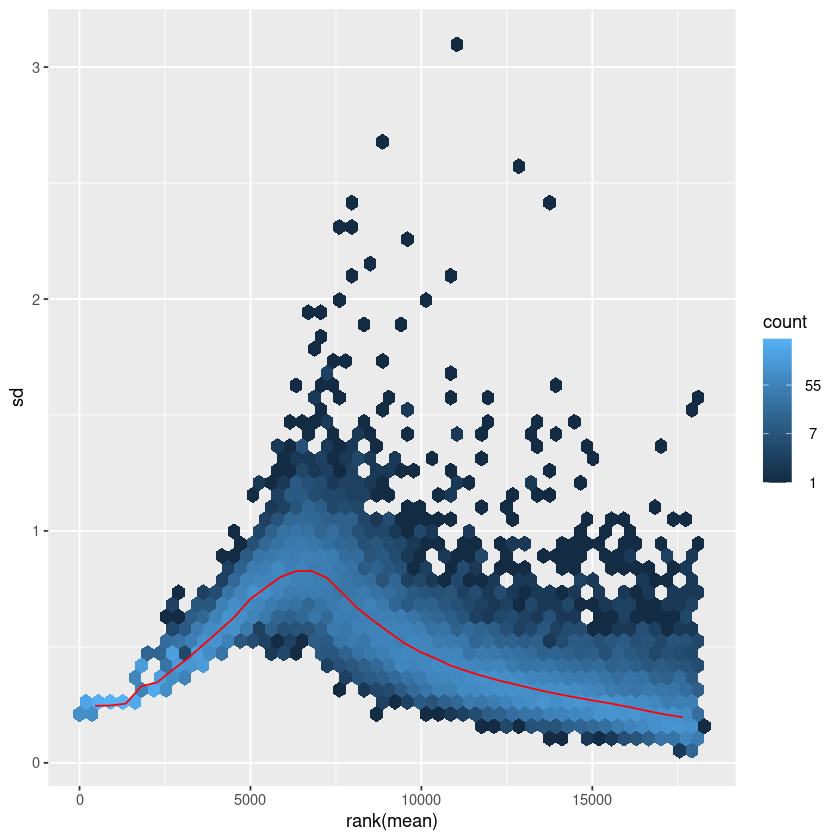

In [72]:
log2.norm.plot <- vsn::meanSdPlot(assay(log2.norm.counts))

<a href="https://www.bioconductor.org/packages/release/bioc/html/vsn.html" rel="noopener noreferrer" target="_blank"><u>In the documentation for the vsn package</u></a>, you can access the ggplot object by pulling it out and modifying it by layering on additional plot components via ggplot2.

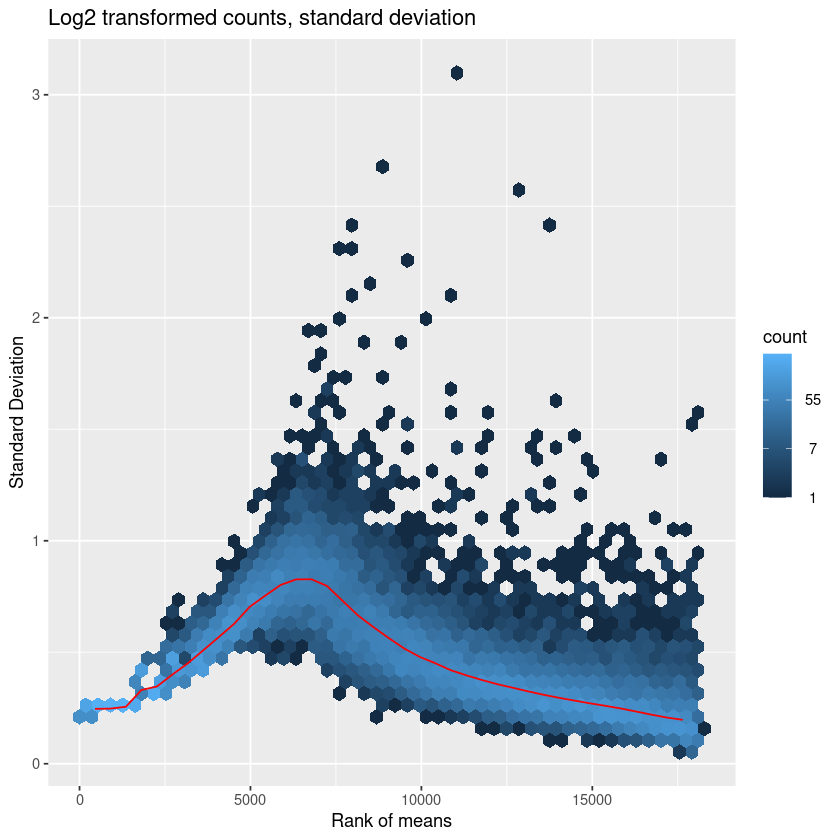

In [73]:
log2.norm.plot$gg +
    ggtitle('Log2 transformed counts, standard deviation') +
    ylab('Standard Deviation') +
    xlab('Rank of means')

<h2>Perform a regularized log (rlog) transformation of data</h2>

Let's compare how the variation looks like when we take into account the fact that lowly expressed genes will have higher variance by performing a regularized log transformation and then plotting the standard deviation of the rlog transformed data.

```
rld <- rlog(dds, blind=FALSE)
```

This type of transformation isn't performed on counts for differential analysis. Instead, this type of transformation is used for data visualization and clustering.

In [74]:
rld <- rlog(dds, blind=FALSE)

In [75]:
head(assay(rld), 5)

,1M_g1_control,1M_g1_tazko,1M_g2_control,1M_g2_tazko,1M_g3_control,1M_g3_tazko,1M_g4_control,1M_g4_tazko,1M_g5_control,1M_g5_tazko,1M_g6_control,1M_g6_tazko,1M_g7_control,1M_g7_tazko,1M_g8_control,1M_g8_tazko
A1BG,0.0419342,0.1352281,0.09043184,0.3021097,0.04164598,0.0904453,0.09011778,0.1361192,0.0878977,0.08694088,0.04205029,0.04247571,0.09417068,0.09414243,0.04305878,0.09268852
A1BG-AS1,0.8753869,0.8272262,0.82991076,0.8247555,0.91766897,0.8750210,0.82936028,0.7821495,0.7800336,0.77878088,0.83061138,0.83201407,0.78824749,0.73845820,0.87999859,0.73722464
A2M,-2.2825675,-2.2827679,-2.28258871,-2.2829329,-2.28263088,-2.2825871,-2.28262545,-2.2826961,-2.2828852,-2.28299716,-2.28254195,-2.28244833,-2.27050913,-2.28215432,-2.28231994,-2.28232462
A2M-AS1,-1.5720585,-1.5726965,-1.46094624,-1.5732218,-1.53520036,-1.5721210,-1.57224301,-1.5724680,-1.5360099,-1.57342627,-1.57197720,-1.57167919,-1.57073271,-1.57074325,-1.57127046,-1.57128538
A4GALT,3.3700307,3.2506366,3.18510262,3.5913851,3.18279319,3.3687201,3.22161911,3.2175693,3.0489680,3.27263515,3.40585055,3.41230075,3.20905287,3.43257236,3.31471832,3.27713057


<h2>Exercise #2: Plot standard deviation after rlog transformation</h2>

Using what you've learned earlier for plotting, and generate a similar plot but with the rlog transformed dataset. 

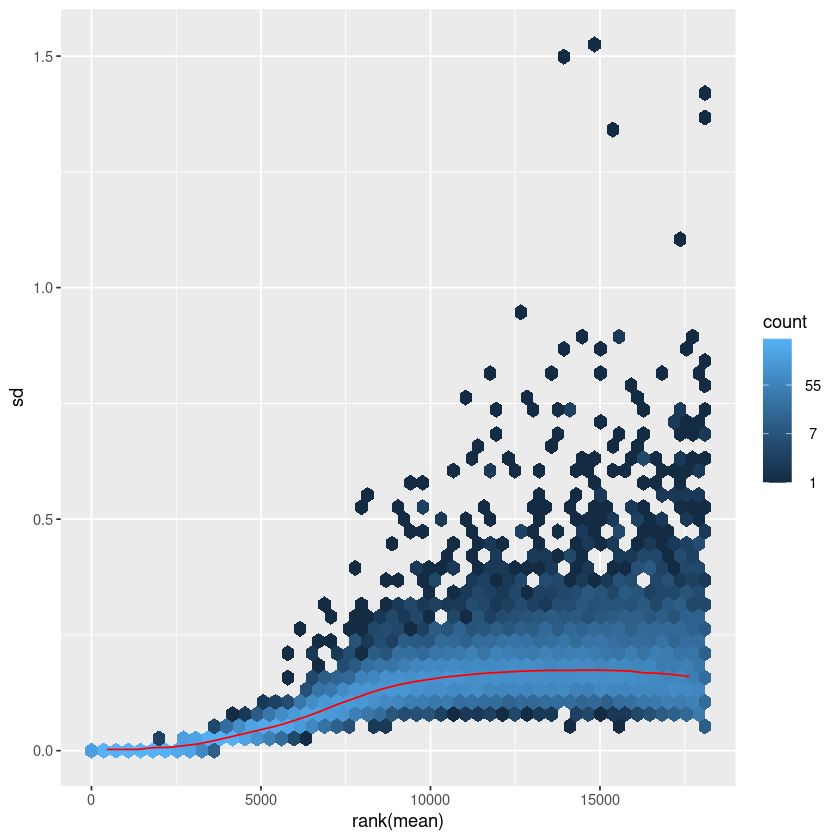

In [76]:
vsn::meanSdPlot(assay(rld))

You should see that the resulting plot looks quite different, and the lower ranked genes no longer have an extremely high variance that swamps out the rest of the dataset.

<h1>Guided Exercise: Pull top 500 variable genes for principal component analysis</h1>

As briefly mentioned previously, we'll focus on the most variable genes in our dataset since that will allow us to perform clustering on our samples. Genes that are not highly variable don't provide much helpful information for us when grouping our samples.

We'll want to work with just the rlog transformed counts, so first, how do we get our rlog transformed counts?

In [77]:
rld.values <- assay(rld)

Once we have our rlog transformed counts, what should we do next?

In [78]:
rld.var.sort <- rld.values[order(rowVars(rld.values), decreasing = TRUE),]

In [79]:
top500.var.rld <- head(rld.var.sort, 500)

<h1>Perform a principal component analysis</h1>

With our top 500 genes that have the highest variance, we can perform a principal component analysis. We'll use the mixOmics package's <code>pca()</code> function to calculate the proportion of explained variance for the first 10 principal components. Then we'll use ggplot2 to generate a biplot, where we plot principal component 1 against principal component 2 and visualize how the clusters separate out from one another.

<a href="https://www.bioconductor.org/packages/release/bioc/manuals/mixOmics/man/mixOmics.pdf" rel="noopener noreferrer" target="_blank"><u>Documentation for mixOmics, including <code>pca()</code> is here.</u></a>

```
pca.out <- mixOmics::pca(t(top500.var.rld), ncomp=10)
```

Let's break down this line of code:

<code>pca.out</code>

This is the variable to which we will assign our PCA results.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&lt;-<code>

This is our assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>mixOmics::</code>

We're calling up a function of the mixOmics package.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>pca()</code>

Specifically, the function that we're calling up is the <code>pca()</code> function.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>t(top500.var.rld)</code>

This argument consists of two parts. The first part is the <code>t()</code> function, which transposes our dataset, much like how we can transpose a pandas DataFrame. Since the <code>pca()</code> function uses the rows to determine clustering, we need to transpose our dataset. The second part is <code>top500.var.rld</code>, which is the dataframe containing our rlog transformed counts. This will be transposed by the <code>t()</code> function, and then passed to the <code>pca()</code> function.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>ncomp = 10</code>

This argument specifies the number of principal components that we will be calculating. We'll calculate ten principal components.

In [80]:
pca.out <- mixOmics::pca(t(top500.var.rld), ncomp=10)

Let's take a look at whats contained in our PCA results.

In [81]:
pca.out

  Eigenvalues for the first 10 principal components, see object$sdev^2: 
       PC1        PC2        PC3        PC4        PC5        PC6        PC7 
95.6773423  7.0375414  2.2052331  1.5623962  1.2383229  1.1239857  1.0131273 
       PC8        PC9       PC10 
 0.9822884  0.7873571  0.7515937 
  
  Proportion of  explained variance for the first 10 principal components, see object$prop_expl_var: 
        PC1              PC2              PC3              PC4      
0.828967231      0.060974637      0.019106571      0.013536907      
        PC5              PC6              PC7              PC8      
0.010729072      0.009738433      0.008777934      0.008510739      
        PC9             PC10      
0.006821816      0.006511955      
  
  Cumulative proportion of  explained variance for the first 10 principal components, see object$cum.var: 
      PC1            PC2            PC3            PC4            PC5      
0.8289672      0.8899419      0.9090484      0.9225853      0.9333

<h1>Guided Exercise: Set up to plot a biplot</h1>

With the results from our principal component analysis, we can begin setting up a biplot, where we plot the first principal component (PC1) against the second one (PC2).

Since PC1 and PC2 together explain the large proportion of the variance in our dataset, we should be able to see samples cluster away from each other. 

And if we plot other principal components, we wouldn't expect such obvious clustering.

<h2>Pull proportion of explained variance into a new dataframe</h2>

To make plotting a little bit simpler, we'll create a new dataframe containing just the proportion of explained variance. So when we want to pull these values to label our axes, we can simply use a similar notation to the one we used in Python.

So first, we'll create the dataframe:

```
pro.var.expl <- as.data.frame(pca.out$prop_expl_var)
```

Breaking down this line of code, we get:

<code>pro.var.expl</code>

This is our variable that will point to our new dataframe.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&lt;-</code>

This is our assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>as.data.frame()</code>

This converts an object into a data frame. Conceptually, it's similar to <code>pd.DataFrame()</code> that we're familiar with in Python. 

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>pca.out</code>

This is the variable to which we previously assigned our PCA results. <a href="https://www.bioconductor.org/packages/release/bioc/manuals/mixOmics/man/mixOmics.pdf" rel="noopener noreferrer" target="_blank"><u>If we dig into the documentation</u></a>, we can see that the output of mixOmics' <code>pca()</code> function is a <code>pca</code> class object that contains different information that we can pull out.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>$</code>

This is an operator in R that allows us to pull out values out of an object, such as a matrix, or in this case a <code>pca</code> class object. 

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>prop_expl_var</code>

We're pulling out a list of values from our variable <code>pca.out</code>, and we're specifically pulling out the proportion of explained variance, which has the value <code>prop_expl_var</code>. 

So with this line of code, we'll have a dataframe that contains the calculated proportion of explained variance for our ten principal components.

In [82]:
pro.var.expl <- as.data.frame(pca.out$prop_expl_var)

Let's take a quick look at the dataframe.

In [83]:
pro.var.expl

,X
,<dbl>
PC1,0.828967231
PC2,0.060974637
PC3,0.019106571
PC4,0.013536907
PC5,0.010729072
PC6,0.009738433
PC7,0.008777934
PC8,0.008510739
PC9,0.006821816


<h2>Pull coordinate values for each sample's principal components</h2>

We can pull out the coordinate information for each of our samples from our <code>pca.out</code> object and use that information to generate a biplot. <a href="https://www.bioconductor.org/packages/release/bioc/manuals/mixOmics/man/mixOmics.pdf" rel="noopener noreferrer" target="_blank"><u>If we dig into the documentation for mixOmics' <code>pca()</code> function</u></a>, we can see that among the things that we can pull from the output, one of them is the <code>variates</code>, which contains the coordinate information for each sample when it's projected on each principal component. Recall from Dr. Ingolia's lecture that principal component analysis is one way of reducing the dimensionality of a dataset while still preserving the information of the original dataset.

So to pull out the coordinate information:

```
pca.coord <- pca.out$variates
```

In [84]:
pca.coord <- pca.out$variates

Let's take a look at the object:

In [85]:
pca.coord

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
1M_g1_control,-14.182332,-2.67080238,0.04984504,-0.8742303,-0.6232536,0.05740141,-0.711873405,0.90011998,0.41219672,-1.445429854
1M_g1_tazko,9.131666,-1.04357915,-0.64398472,0.8369952,-1.3693701,1.86377093,0.363358144,0.95289639,0.93620166,1.760705998
1M_g2_control,-14.124022,-2.52718416,1.12720263,-0.5920668,-1.5408791,-0.77569742,0.494431379,0.85456617,0.71368239,0.251326473
1M_g2_tazko,9.245397,-1.40512842,0.14303933,1.9581032,-0.7282176,-0.34936158,-0.793147521,-0.13801971,0.09508105,-0.659839047
1M_g3_control,-10.180357,-0.07246890,-0.10090396,1.4771638,1.2135960,1.01042236,-0.516621002,-0.02443973,-0.01262746,0.006768248
1M_g3_tazko,9.318155,-1.52065995,-2.27432509,-0.3501834,1.1454613,0.28535546,-0.897662445,1.85407519,-1.31125512,-0.208878368
1M_g4_control,-8.773776,0.35217129,-0.18436386,1.1962005,2.0429465,0.44011882,2.385595270,-0.07578801,0.61720221,-0.219259469
1M_g4_tazko,9.272750,-1.67579780,-2.17594357,-0.7073819,0.3105435,-1.70835192,-0.002372558,-1.47349801,1.27785897,0.551035758
1M_g5_control,-10.906855,-1.10815295,-0.77875485,-0.2644528,0.1374340,-1.15324724,-0.726049355,-0.73363784,-0.60882289,1.090953149
1M_g5_tazko,9.304937,-1.44582958,-0.83275335,0.5887307,-0.5715043,-0.41892738,1.275711777,-0.59532529,-0.63384829,-1.463242799


We can then pull out the matrix contained within the list <code>X</code> to use to create our dataframe:

```
pca.coord <- pca.coord$X
```

In [86]:
pca.coord <- pca.coord$X

In [87]:
pca.coord

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
1M_g1_control,-14.182332,-2.67080238,0.04984504,-0.8742303,-0.6232536,0.05740141,-0.711873405,0.90011998,0.41219672,-1.445429854
1M_g1_tazko,9.131666,-1.04357915,-0.64398472,0.8369952,-1.3693701,1.86377093,0.363358144,0.95289639,0.93620166,1.760705998
1M_g2_control,-14.124022,-2.52718416,1.12720263,-0.5920668,-1.5408791,-0.77569742,0.494431379,0.85456617,0.71368239,0.251326473
1M_g2_tazko,9.245397,-1.40512842,0.14303933,1.9581032,-0.7282176,-0.34936158,-0.793147521,-0.13801971,0.09508105,-0.659839047
1M_g3_control,-10.180357,-0.07246890,-0.10090396,1.4771638,1.2135960,1.01042236,-0.516621002,-0.02443973,-0.01262746,0.006768248
1M_g3_tazko,9.318155,-1.52065995,-2.27432509,-0.3501834,1.1454613,0.28535546,-0.897662445,1.85407519,-1.31125512,-0.208878368
1M_g4_control,-8.773776,0.35217129,-0.18436386,1.1962005,2.0429465,0.44011882,2.385595270,-0.07578801,0.61720221,-0.219259469
1M_g4_tazko,9.272750,-1.67579780,-2.17594357,-0.7073819,0.3105435,-1.70835192,-0.002372558,-1.47349801,1.27785897,0.551035758
1M_g5_control,-10.906855,-1.10815295,-0.77875485,-0.2644528,0.1374340,-1.15324724,-0.726049355,-0.73363784,-0.60882289,1.090953149
1M_g5_tazko,9.304937,-1.44582958,-0.83275335,0.5887307,-0.5715043,-0.41892738,1.275711777,-0.59532529,-0.63384829,-1.463242799


And we can create a dataframe from it:

```
pca.coord <- as.data.frame(pca.coord)
```

In [88]:
pca.coord <- as.data.frame(pca.coord)

In [89]:
head(pca.coord, 5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1M_g1_control,-14.182332,-2.6708024,0.04984504,-0.8742303,-0.6232536,0.05740141,-0.7118734,0.90011998,0.41219672,-1.445429854
1M_g1_tazko,9.131666,-1.0435791,-0.64398472,0.8369952,-1.3693701,1.86377093,0.3633581,0.95289639,0.93620166,1.760705998
1M_g2_control,-14.124022,-2.5271842,1.12720263,-0.5920668,-1.5408791,-0.77569742,0.4944314,0.85456617,0.71368239,0.251326473
1M_g2_tazko,9.245397,-1.4051284,0.14303933,1.9581032,-0.7282176,-0.34936158,-0.7931475,-0.13801971,0.09508105,-0.659839047
1M_g3_control,-10.180357,-0.0724689,-0.10090396,1.4771638,1.2135960,1.01042236,-0.5166210,-0.02443973,-0.01262746,0.006768248


We can also do this in a single line as follows:

```
pca.coord <- as.data.frame(pca.out$variates$X)
```

And another alternative is that we can subsitute <code>$variates$X</code> with <code>$x</code> (lower case x) to directly get the coordinates matrix.

```
pca.coord <- as.data.frame(pca.out$x)
```

In [90]:
pca.coord <- as.data.frame(pca.out$x)

In [91]:
head(pca.coord, 5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1M_g1_control,-14.182332,-2.6708024,0.04984504,-0.8742303,-0.6232536,0.05740141,-0.7118734,0.90011998,0.41219672,-1.445429854
1M_g1_tazko,9.131666,-1.0435791,-0.64398472,0.8369952,-1.3693701,1.86377093,0.3633581,0.95289639,0.93620166,1.760705998
1M_g2_control,-14.124022,-2.5271842,1.12720263,-0.5920668,-1.5408791,-0.77569742,0.4944314,0.85456617,0.71368239,0.251326473
1M_g2_tazko,9.245397,-1.4051284,0.14303933,1.9581032,-0.7282176,-0.34936158,-0.7931475,-0.13801971,0.09508105,-0.659839047
1M_g3_control,-10.180357,-0.0724689,-0.10090396,1.4771638,1.2135960,1.01042236,-0.5166210,-0.02443973,-0.01262746,0.006768248


<h2>Plot biplot of PC1 vs PC2</h2>

With the coordinates for our principal components, we can generate biplots to visualize the groupings of our samples. This can help us to determine if there may have been batch effects or potential issues with a sample that we may want to keep in mind during our differential expression analysis.

To generate these plots, we'll make use of ggplot2 first by starting with a basic ggplot object and then layering on additional plot components on top of it.

Saving 7 x 7 in image


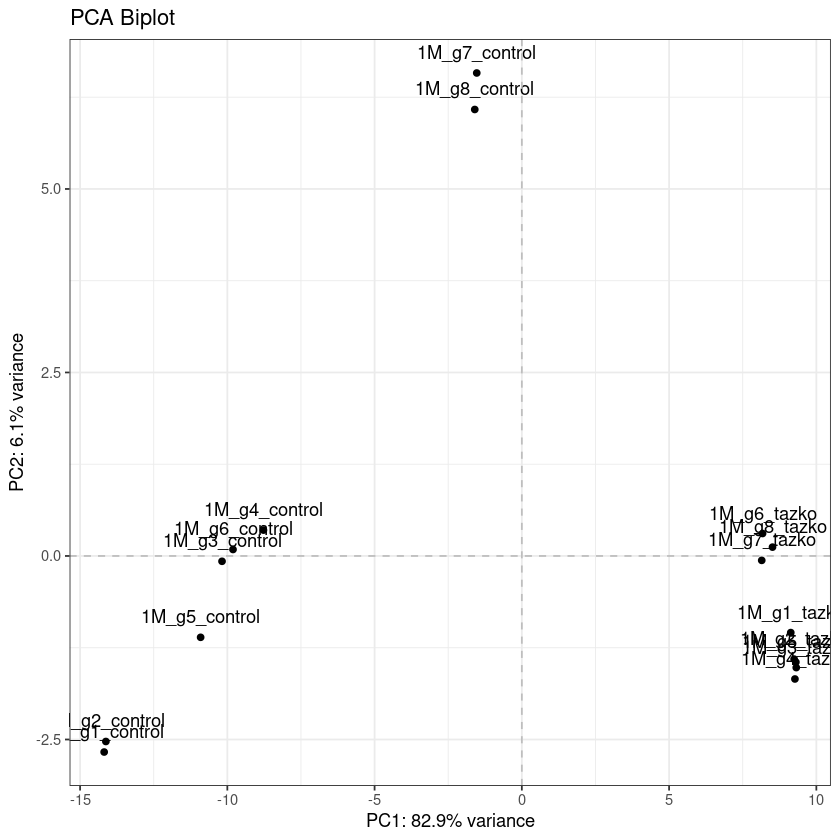

In [100]:
ggplot(pca.coord, aes(x=PC1, y=PC2)) +
    geom_point() +
    geom_text(aes(label=rownames(pca.coord)),
              hjust=0.5,
              vjust=-1) +
    theme_bw() +
    guides(fill=guide_legend(titles=NULL)) +
    ggtitle('PCA Biplot') +
    xlab(paste0('PC1: ', 
                round((pro.var.expl$X[1])*100, digits=2), 
                '% variance')) +
    ylab(paste0('PC2: ', 
                round((pro.var.expl$X[2])*100, digits=2), 
                '% variance')) +
    geom_hline(yintercept = 0,
               linetype = 'dashed',
               colour = 'grey'
               ) +
    geom_vline(xintercept = 0,
               linetype = 'dashed',
               colour = 'grey'
               )

ggsave('PCA_biplot_PC1_PC2.pdf')

<h2>Exercise #3: Plot a biplot of PC2 vs PC3</h2>

See if you can set up a biplot using the coordinates for PC2 and PC3, seeing what you can substitute out from the above code that we used to generate a biplot of PC1 vs PC2.

Saving 7 x 7 in image


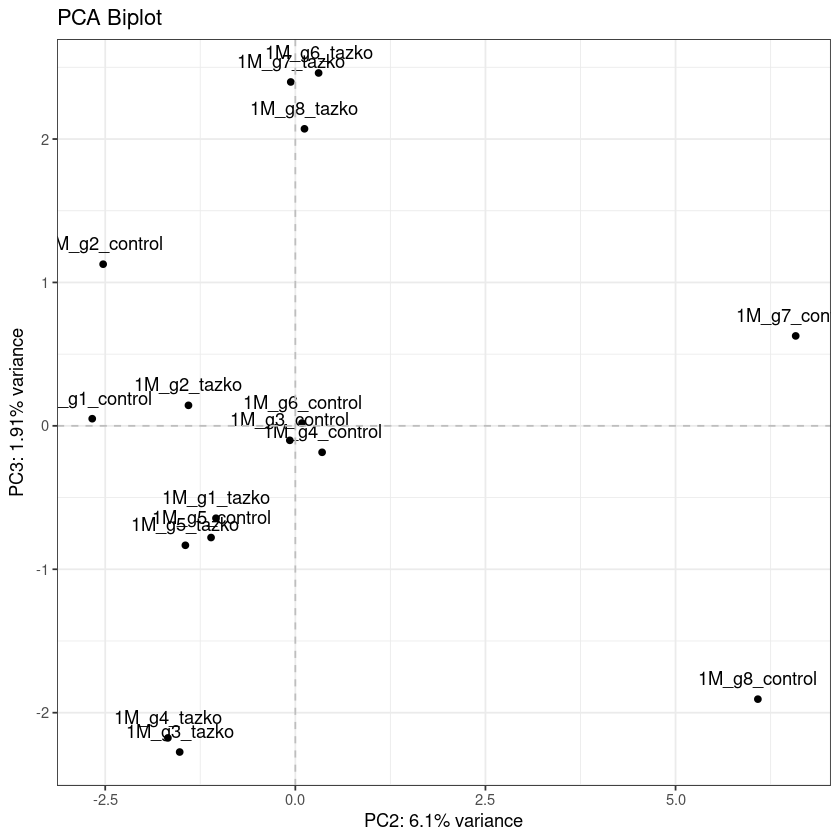

In [102]:
ggplot(pca.coord, aes(x=PC2, y=PC3)) +
    geom_point() +
    geom_text(aes(label=rownames(pca.coord)),
              hjust=0.5,
              vjust=-1) +
    theme_bw() +
    guides(fill=guide_legend(titles=NULL)) +
    ggtitle('PCA Biplot') +
    xlab(paste0('PC2: ', 
                round((pro.var.expl$X[2])*100, digits=2), 
                '% variance')) +
    ylab(paste0('PC3: ', 
                round((pro.var.expl$X[3])*100, digits=2), 
                '% variance')) +
    geom_hline(yintercept = 0,
               linetype = 'dashed',
               colour = 'grey'
               ) +
    geom_vline(xintercept = 0,
               linetype = 'dashed',
               colour = 'grey'
               )

ggsave('PCA_biplot_PC2_PC3.pdf')

What do you see for this biplot and how does it compare to PC1 vs PC2?

<h1 style="font-size: 40px; margin-bottom: 0px;">References</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 400px;"></hr>

<p><a href="https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8" rel="noopener noreferrer" target="_blank"><u>Love et al 2014 Genome Biol:</u></a> Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2</p>

<p><a href="https://ggplot2.tidyverse.org" rel="noopener noreferrer" target="_blank"><u>H. Wickham. ggplot2: Elegant Graphics for Data Analysis. Springer-Verlag New York, 2016.</u></a></p>

<p><a href="https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005752" rel="noopener noreferrer" target="_blank"><u>Rohart et al 2017 PLoS Comp Biol:</u></a> mixOmics: An R package for ‘omics feature selection and multiple data integration</p>